In [23]:
import numpy as np
import os
from PIL import Image
from PIL import ImageDraw
import os
import xml.etree.ElementTree as ET
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN
from torchvision.models import resnet50
from torchvision.models.detection.rpn import AnchorGenerator

In [2]:
# function to load images from specified folder path
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            try:
                img = Image.open(img_path)
                images.append(img)
            except Exception as e:
                print(f"Error loading image: {img_path} - {e}")
    return images

In [3]:
# Finds class and boundary box data in .xml files 
def parse_xml_label(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Extract image size 
    size_elem = root.find('size')
    width = int(size_elem.find('width').text)
    height = int(size_elem.find('height').text)
    depth = int(size_elem.find('depth').text)

    # Extract object annotations
    annotations = []
    for obj_elem in root.findall('object'):
        name = obj_elem.find('name').text
        bbox_elem = obj_elem.find('bndbox')
        xmin = float(bbox_elem.find('xmin').text)
        ymin = float(bbox_elem.find('ymin').text)
        xmax = float(bbox_elem.find('xmax').text)
        ymax = float(bbox_elem.find('ymax').text)
        annotations.append({
            'name': name,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax
        })

    return width, height, depth, annotations

In [4]:
# Specify the folder path containing the images
folder_path = './images'

# Load images from the folder
original_images = load_images_from_folder(folder_path)

In [6]:
# Specify the directory path containing the XML labels
labels_dir = './data'

# Load .xml labels for all files in the directory
# This is a dictionary object
labels = {}
for filename in os.listdir(labels_dir):
    if filename.endswith('.xml'):
        xml_path = os.path.join(labels_dir, filename)
        width, height, depth, annotations = parse_xml_label(xml_path)
        labels[filename] = {
            'width': width,
            'height': height,
            'depth': depth,
            'annotations': annotations
        }

In [7]:
# This is a class for the data loader for images and labels
class YourDataset(Dataset):
    def __init__(self, images, labels, target_size):
        self.images = images
        self.labels = labels
        self.target_size = target_size
        self.transform = transforms.Compose([
            transforms.Resize(target_size),  # resize the image before converting to a tensor
            transforms.ToTensor(),  # then convert to a tensor
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        # Here the index is passed to a list for images but the labels are a dict so the index is 
        # converted to a key
        label_index = index + 1
        key = f"{label_index}.xml"  
        label = labels[key]
    
        # Transforms the image into appropriate sized tensor
        image_tensor = self.transform(image)
    
        # Convert the annotations to tensors
        annotations = label.get('annotations', [])
        annotation_tensors = []
        # This dictionary is for classification of the defects
        class_to_label = {'Point': 0, 'Void': 1, 'Other': 2, 'unlabelled': 0}
        # Here the anotations of the label are turned into tensors
        for annotation in annotations:
            name = annotation.get('name')
            class_label = class_to_label.get(name, class_to_label['unlabelled']) 
            xmin = annotation.get('xmin', 0)
            ymin = annotation.get('ymin', 0)
            xmax = annotation.get('xmax', 0)
            ymax = annotation.get('ymax', 0)
            
            annotation_tensor = torch.tensor([class_label, xmin, ymin, xmax, ymax])
            annotation_tensors.append(annotation_tensor)
        # This is done so that the target tensors are the same length
        max_annotations = 171
        while len(annotation_tensors) < max_annotations:
            # Append padding annotation
            # These are weird since the padded boundary box has to be a positive box
            pad_tensor = torch.tensor([0.001, 0.001, 0.002, 0.002, 0.003])  # Padding value
            annotation_tensors.append(pad_tensor)
        # Stack the bounding boxes into a single tensor for each image
        annotation_tensors = torch.stack(annotation_tensors)  
        return image_tensor, annotation_tensors

### The below Resnet Classes are only used as parameters for the optimizer

In [8]:

# Define the residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = torch.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = torch.relu(out)
        return out


# Define the ResNet
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1)) # this will make the output size to be (batch_size, num_channels, 1, 1)
        out = torch.flatten(out, 1) # flatten the tensor starting from dimension 1
        out = self.linear(out)
        return out


# Create the ResNet34
def ResNet34():
    return ResNet(ResidualBlock, [3, 4, 6, 3])


In [9]:
# Create an instance of your Dataset
dataset = YourDataset(original_images, labels, (256, 256))

# Load the data from your Dataset
dataloader = DataLoader(dataset, batch_size=1) 

# Instantiate the model
num_classes = 5 # 4 classes + 1 for background
model = ResNet34()
model.fc = nn.Linear(512, num_classes) # Replace the last fc layer

# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# number of epochs
num_epochs = 10



In [24]:
def get_object_detection_model(num_classes):
    # Load pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=True)
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [25]:
model = get_object_detection_model(num_classes)
# Training loop
for epoch in range(num_epochs):
    print(f"Epoch {epoch}/{num_epochs}")
    model.train()
    
    for i, (images, annotations) in enumerate(dataloader):
    # Extract boxes and impclass from annotations
        impclass = annotations[:, :, 0]
        boxes = annotations[:, :, 1:]

    # Create targets
    targets = []
    for b, c in zip(boxes, impclass):
        targets.append({
            'boxes': b,  # Should be a FloatTensor of shape [n_boxes, 4]
            'labels': c.long(),  # Should be a LongTensor of shape [n_boxes]
        })
    
    # Forward
    loss_dict = model(images, targets)
    # The model returns a dict where the total loss is the sum of all losses
    losses = sum(loss for loss in loss_dict.values())

    # Backward
    optimizer.zero_grad()
    losses.backward()
    optimizer.step()



Epoch 0/10
Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10


In [33]:
# Load image and its target from the dataset
image, target = dataset[1]


In [28]:
# Set model to evaluation mode
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [34]:
# Disable computation of gradients
with torch.no_grad():
    # Get the prediction from the model
    prediction = model([image])

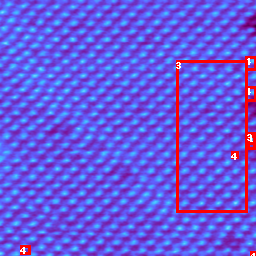

In [37]:
def draw_boxes(image, boxes, labels, scores, threshold=0.33):
    # Convert the image from PyTorch tensor to a PIL image and draw the bounding boxes
    image = transforms.ToPILImage()(image.cpu())
    draw = ImageDraw.Draw(image)
    
    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red', width=3)
            draw.text((box[0], box[1]), text=str(label.item()))
    return image

# To draw boxes on the first image
draw_boxes(image, prediction[0]['boxes'], prediction[0]['labels'], prediction[0]['scores'])

